#Importing the packages

In [ ]:
pip install emoji

In [ ]:
import pandas as pd
import numpy as np 
import seaborn
import matplotlib
import plotly
import sklearn 
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


In [147]:
import re
import string

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

#Importing data

In [139]:
df=pd.read_csv("/content/cyberbullying_tweets.csv")  

In [140]:
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [141]:
df=df.rename(columns={"tweet_text":"text", "cyberbullying_type": "type"})

In [142]:
df["type"].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [143]:
df["type"].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: type, dtype: int64

In [144]:
df.isnull().sum() #no missing values

text    0
type    0
dtype: int64

In [145]:
#applying Ordinal encoding as there are no missing data

df["type"]=df["type"].replace({"religion": 1, "age": 2, 
                               "ethnicity": 3, "gender": 4, 
                               "other_cyberbullying": 5,
                               "not_cyberbullying": 6})
df

,text,type
0,"In other words #katandandre, your food was cra...",6
1,Why is #aussietv so white? #MKR #theblock #ImA...,6
2,@XochitlSuckkks a classy whore? Or more red ve...,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",6
4,@RudhoeEnglish This is an ISIS account pretend...,6
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",3
47688,Turner did not withhold his disappointment. Tu...,3
47689,I swear to God. This dumb nigger bitch. I have...,3
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,3


#Cleaning & Processing the text


In [146]:
def remove_emoji(text):
  return emoji.replace_emoji(text, "")

In [148]:
#further cleaning of the text
stop_words = set(stopwords.words('english'))
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopchars= string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

In [149]:
#removing contractions
def remove_contractions(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [150]:
#clean hashtags
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    updated_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return updated_tweet2

In [151]:
#remove extra spaces in the text
def remove_extra_spaces(text):
    return re.sub("\s\s+" , " ", text)

In [152]:
#filter special characters
def filter_special_char(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

In [153]:
#stem the words
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

In [154]:
#lemmatizing the words
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(words) for words in tokenized])

In [155]:
#final function to pre-process text by using all the functions
def preprocess(text):
    text = remove_emoji(text)
    text = remove_contractions(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_special_char(text)
    text = remove_extra_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    return text

In [156]:
#creating another column in the DataFrame with all the cleaned text
df['cleaned_text'] = df['text'].apply(preprocess)
df

,text,type,cleaned_text
0,"In other words #katandandre, your food was cra...",6,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,6,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,6,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",6,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,6,isi account pretend kurdish account like islam...
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",3,black ppl expect anyth depend anyth yet free p...
47688,Turner did not withhold his disappointment. Tu...,3,turner withhold disappoint turner call court a...
47689,I swear to God. This dumb nigger bitch. I have...,3,swear god dumb nigger bitch got bleach hair re...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,3,yea fuck rt your nigger fuck unfollow fuck dum...


In [157]:
df["cleaned_text"].duplicated().sum()

3041

In [158]:
#deleting the duplicate data
df.drop_duplicates("cleaned_text", inplace=True) 

In [159]:
#tokenizing the words in text
df['tweet_list'] = df['cleaned_text'].apply(word_tokenize)
df

,text,type,cleaned_text,tweet_list
0,"In other words #katandandre, your food was cra...",6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d..."
4,@RudhoeEnglish This is an ISIS account pretend...,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like..."
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",3,black ppl expect anyth depend anyth yet free p...,"[black, ppl, expect, anyth, depend, anyth, yet..."
47688,Turner did not withhold his disappointment. Tu...,3,turner withhold disappoint turner call court a...,"[turner, withhold, disappoint, turner, call, c..."
47689,I swear to God. This dumb nigger bitch. I have...,3,swear god dumb nigger bitch got bleach hair re...,"[swear, god, dumb, nigger, bitch, got, bleach,..."
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,3,yea fuck rt your nigger fuck unfollow fuck dum...,"[yea, fuck, rt, your, nigger, fuck, unfollow, ..."


In [160]:
#finding the length of each tweet

length=[]
for t in df["tweet_list"]:
  tweet_l=len(t)
  length.append(tweet_l)
#making a new column that stores the length
df["text_length"]=length
df

,text,type,cleaned_text,tweet_list,text_length
0,"In other words #katandandre, your food was cra...",6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11
2,@XochitlSuckkks a classy whore? Or more red ve...,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d...",9
4,@RudhoeEnglish This is an ISIS account pretend...,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like...",8
...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",3,black ppl expect anyth depend anyth yet free p...,"[black, ppl, expect, anyth, depend, anyth, yet...",21
47688,Turner did not withhold his disappointment. Tu...,3,turner withhold disappoint turner call court a...,"[turner, withhold, disappoint, turner, call, c...",29
47689,I swear to God. This dumb nigger bitch. I have...,3,swear god dumb nigger bitch got bleach hair re...,"[swear, god, dumb, nigger, bitch, got, bleach,...",13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,3,yea fuck rt your nigger fuck unfollow fuck dum...,"[yea, fuck, rt, your, nigger, fuck, unfollow, ...",10


In [161]:
#removing tweets with no words
df=df[df["text_length"]!=0]

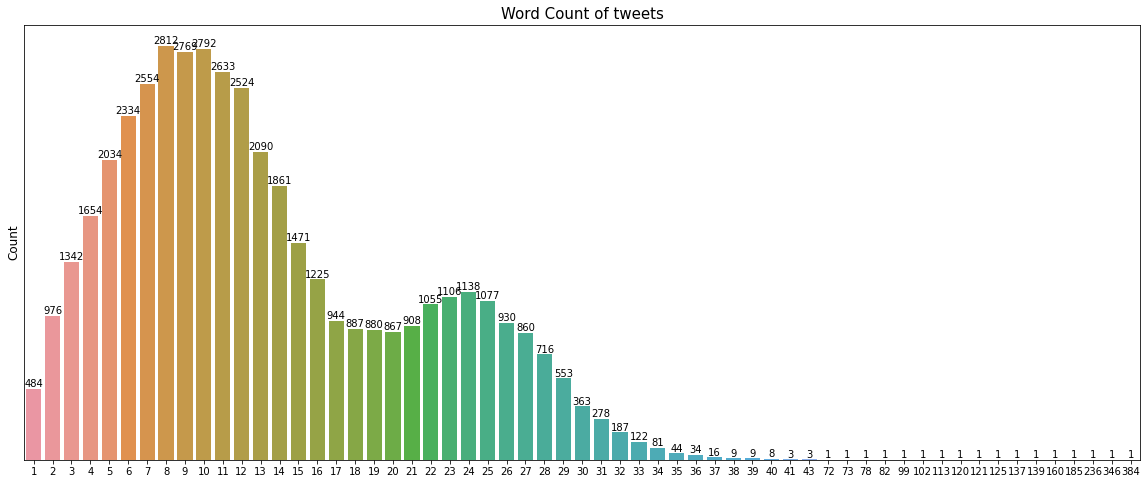

In [162]:
plt.figure(figsize=(20,8))
ax = sns.countplot(x='text_length', data=df)
plt.title('Word Count of tweets', fontsize=15)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('')

plt.show()

In [163]:
#Creating multiple dataframes for each type of cyber bullying
religion_type=df[df["type"]==1]
age_type=df[df["type"]==2]
ethnicity_type=df[df["type"]==3]
gender_type=df[df["type"]==4]
other_cyberbullying_type=df[df["type"]==5]
not_cyberbullying_type=df[df["type"]==6]

In [164]:
def top20words(bully_type):
  df=Counter([item for sublist in bully_type['tweet_list'] for item in sublist])
  top20 = pd.DataFrame(df.most_common(20))
  top20.columns = ['Top Words','Count']
  return top20.style.background_gradient(cmap='YlOrRd'), top20 

In [165]:
def bar_plot(df):
  fig=plt.figure(figsize=(16,9))
  sns.barplot(data=df, x="Top Words", y="Count")
  plt.show()

In [166]:
#function to plot the word clouds

def plot_wordcloud(cyberbullying_type, encoding_type):
    string = ""
    for i in df[df.type == encoding_type].cleaned_text.values:
        string = string + " " + i.strip()


    custom_mask = np.array(Image.open('/content/twitter_mask.png'))
    wordcloud = WordCloud(background_color ='white',max_words=2000, max_font_size=256,
               random_state=42, width=custom_mask.shape[1],height=custom_mask.shape[0],
                mask = custom_mask,min_font_size = 10,colormap='Set2').generate(string)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(cyberbullying_type)
    plt.show()
    del string

# Religion Based Cyberbullying

ValueError: ignored

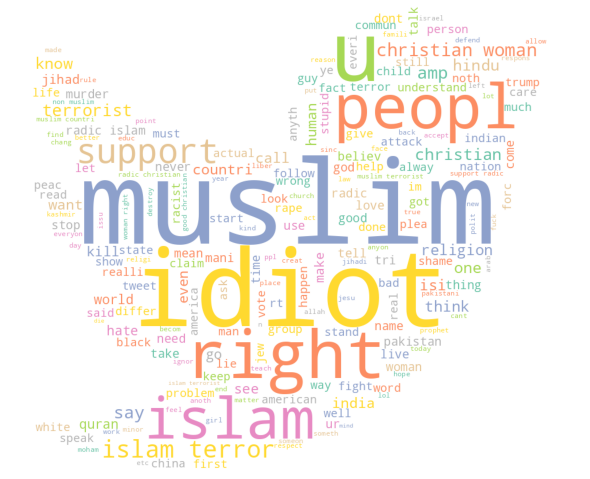

In [204]:
plot_wordcloud(religion_type, 1 )

In [168]:
#top 20 cyberbullying words for the RELIGION category
x, y = top20words(religion_type)
x

,Top Words,Count
0,muslim,4618
1,idiot,3075
2,islam,2440
3,christian,2132
4,u,1922
5,terrorist,1378
6,right,1289
7,like,1276
8,support,1251
9,woman,1247


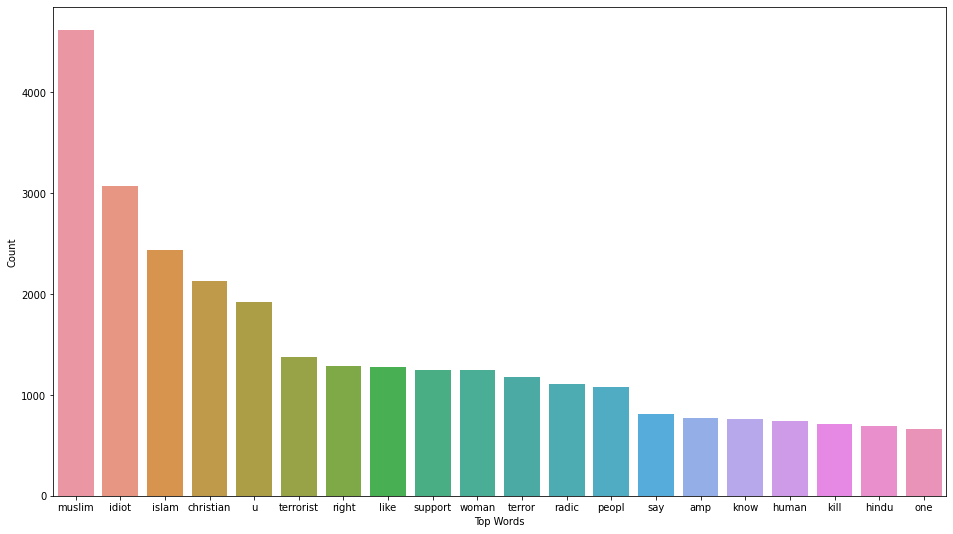

In [169]:
bar_plot(y)

# Age Based Cyberbullying

ValueError: ignored

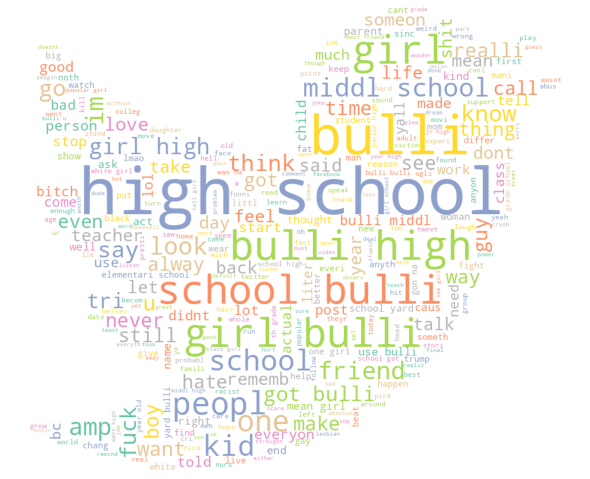

In [205]:
plot_wordcloud(age_type, 2 )

In [171]:
#top 20 cyberbullying words for the AGE category
x,y=top20words(age_type)
x

,Top Words,Count
0,bulli,8899
1,school,8426
2,high,4861
3,girl,4616
4,like,2076
5,get,1051
6,one,1044
7,peopl,934
8,got,842
9,kid,809


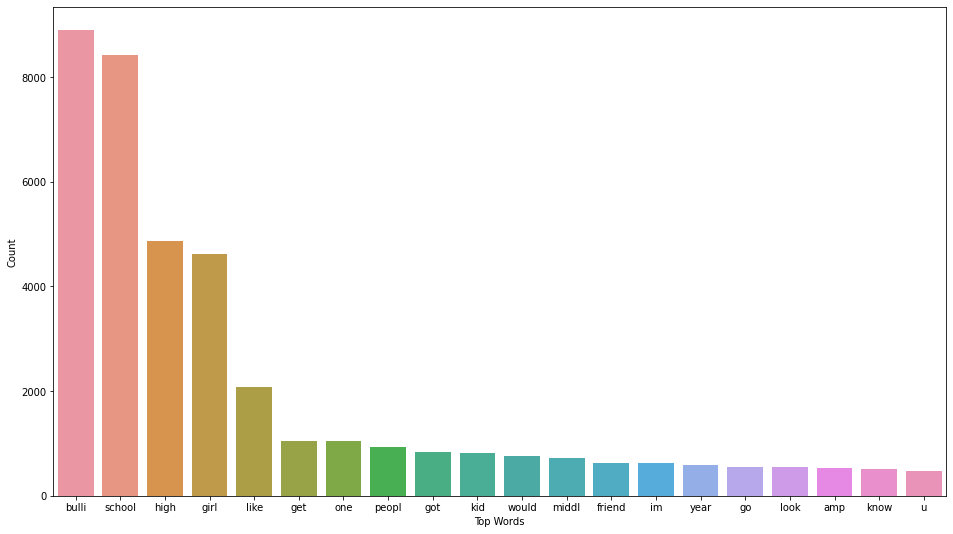

In [172]:
bar_plot(y)

# Ethnicity Based Cyberbullying

ValueError: ignored

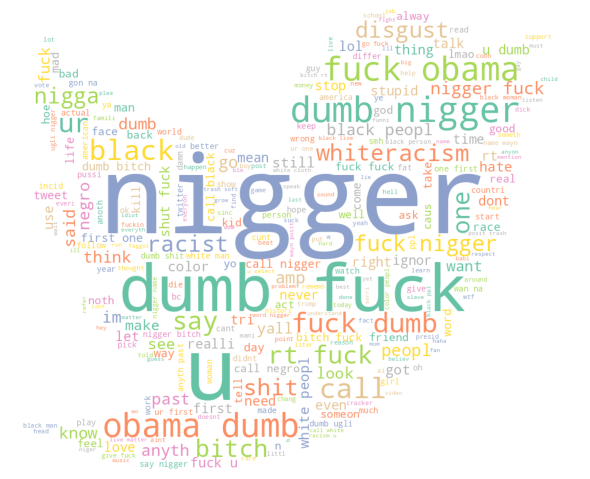

In [206]:
plot_wordcloud(ethnicity_type, 3 )

In [174]:
#top 20 cyberbullying words for the ETHNICITY category
x,y=top20words(ethnicity_type)
x

,Top Words,Count
0,fuck,5892
1,nigger,5456
2,dumb,5003
3,as,2241
4,black,2134
5,u,2107
6,white,1557
7,call,1381
8,peopl,1182
9,rt,1166


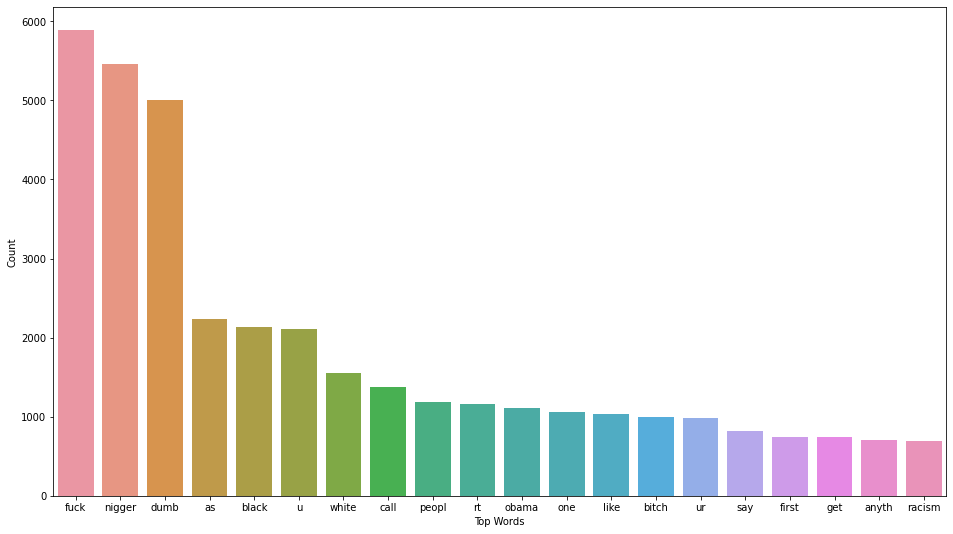

In [175]:
bar_plot(y)

# Gender Based Cyberbullying

ValueError: ignored

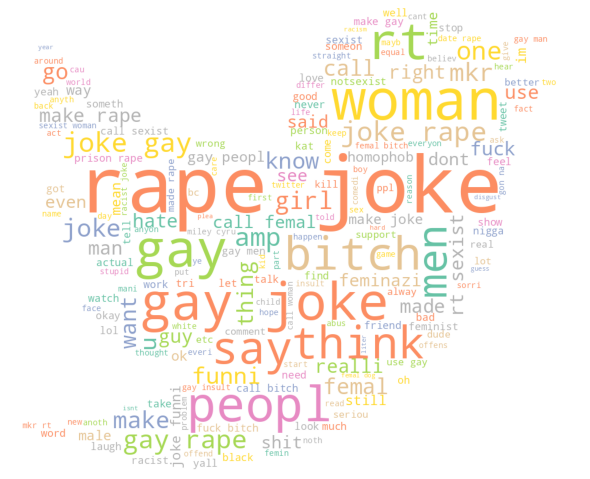

In [208]:
plot_wordcloud(gender_type, 4 )

In [177]:
#top 20 cyberbullying words for the GENDER category
x,y=top20words(gender_type)
x

,Top Words,Count
0,joke,5179
1,rape,4070
2,gay,3852
3,call,1401
4,make,1283
5,rt,1221
6,woman,1182
7,bitch,1146
8,femal,1108
9,peopl,988


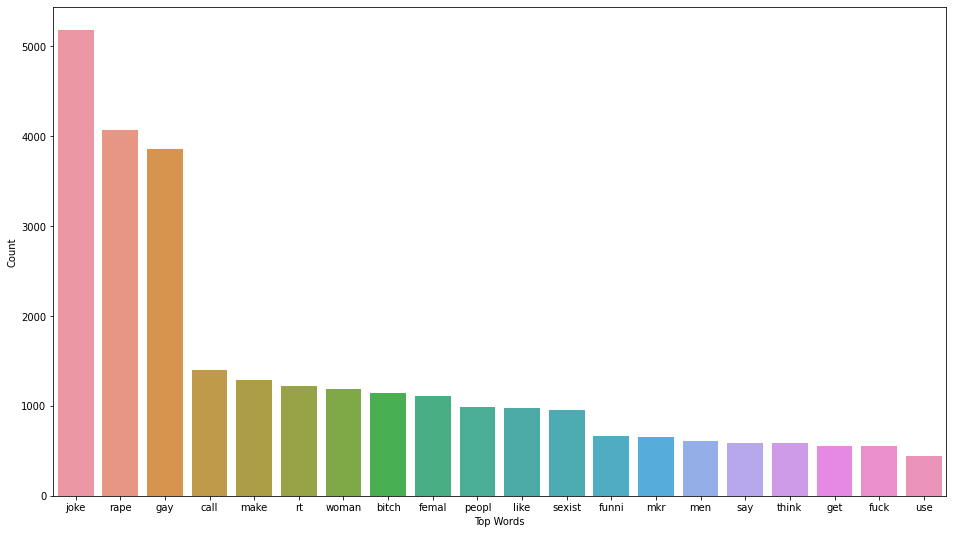

In [178]:
bar_plot(y)

# Other Cyberbullying Type

ValueError: ignored

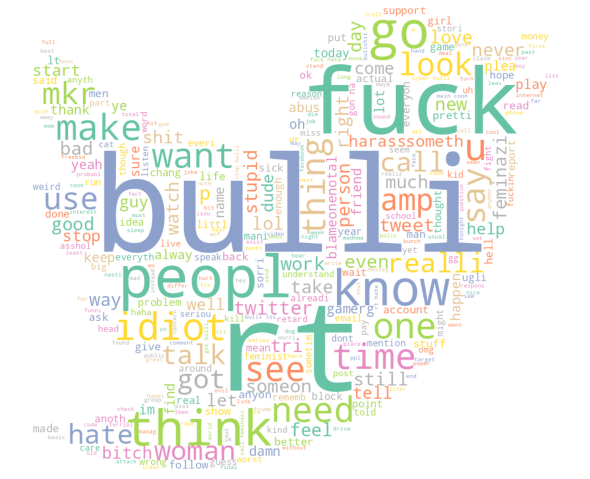

In [209]:
plot_wordcloud(other_cyberbullying_type, 5 )

In [180]:
#top 20 cyberbullying words for the OTHER CYBERBULLYING category
x,y=top20words(other_cyberbullying_type)
x

,Top Words,Count
0,bulli,882
1,rt,727
2,fuck,509
3,like,424
4,get,393
5,peopl,353
6,go,277
7,idiot,261
8,know,241
9,think,237


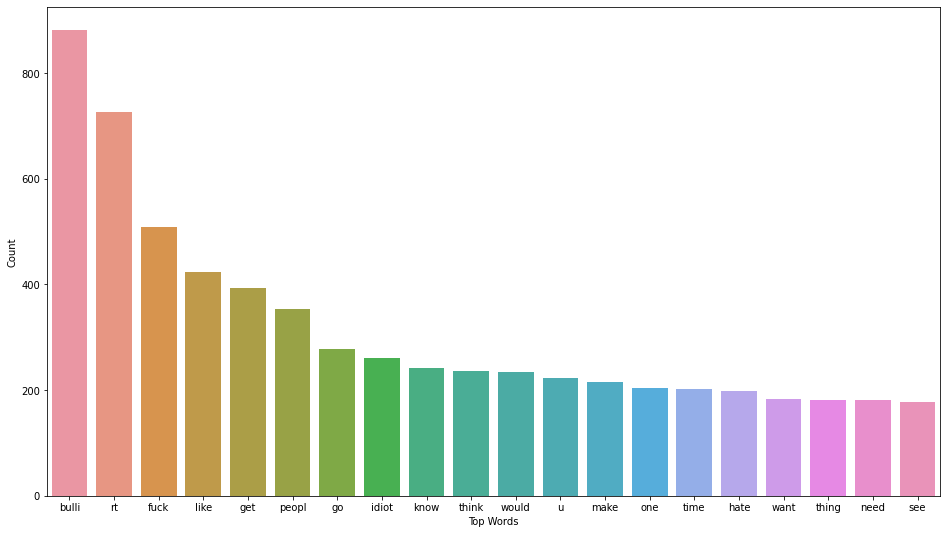

In [181]:
bar_plot(y)

#Not Cyberbullying 

ValueError: ignored

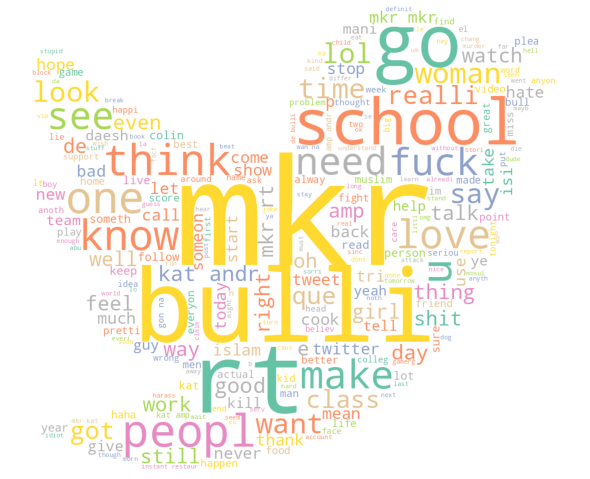

In [210]:
plot_wordcloud(not_cyberbullying_type, 6 )

In [183]:
#top 20 cyberbullying words for the NOT CYBERBULLYING category
x,y=top20words(not_cyberbullying_type)
x

,Top Words,Count
0,mkr,1674
1,bulli,1102
2,rt,785
3,like,424
4,get,423
5,go,394
6,school,374
7,kat,286
8,would,286
9,peopl,272


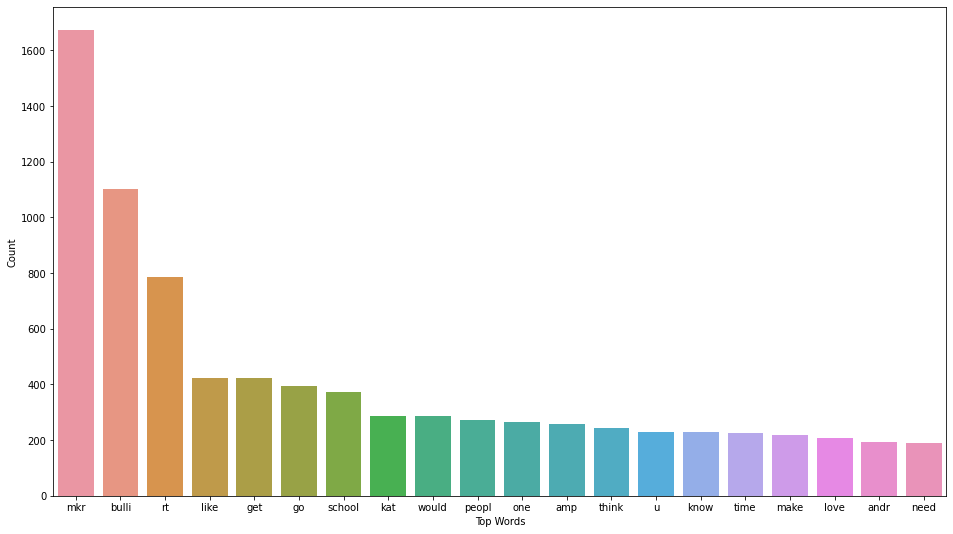

In [184]:
bar_plot(y)

#Creating the ML Model

In [185]:
X,y = df['cleaned_text'],df['type']

In [186]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(33487,) (33487,) (11163,) (11163,)


#tf-idf Vectorization

In [187]:
tf_idf = TfidfVectorizer()
train_X_tf = tf_idf.fit_transform(train_X)
val_X_tf = tf_idf.transform(val_X)
print(train_X_tf.shape)
print(val_X_tf.shape)

(33487, 30729)
(11163, 30729)


#Implementing Different Models

In [188]:
#Linear Support Vector Classifier

lin_svc = LinearSVC()
lin_svc_cv_score = cross_val_score(lin_svc,train_X_tf,train_y,cv=5,scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv


0.8211908336011708

In [189]:
#Decison Tree Classifier

dtree = DecisionTreeClassifier()
dtree_cv_score = cross_val_score(dtree,train_X_tf,train_y,cv=5,scoring='f1_macro',n_jobs=-1)
mean_dtree_cv = np.mean(dtree_cv_score)
mean_dtree_cv

0.8093763426790833

In [190]:
#Random Forest Classifier

rand_forest = RandomForestClassifier(max_depth=20)
rand_forest_cv_score = cross_val_score(rand_forest,train_X_tf,train_y,cv=5, scoring='f1_macro',n_jobs=-1)
mean_rand_forest_cv = np.mean(rand_forest_cv_score)
mean_rand_forest_cv

0.7105571531505074

In [191]:
#Logistic Regression

log_reg = LogisticRegression()
log_cv_score = cross_val_score(log_reg,train_X_tf,train_y,cv=5,scoring='f1_macro',n_jobs=-1)
mean_log_cv = np.mean(log_cv_score)
mean_log_cv

0.8234308016688434

In [192]:
#Naive Bayes Classifier

multiNB = MultinomialNB()
multiNB_cv_score = cross_val_score(multiNB,train_X_tf,train_y,cv=5,scoring='f1_macro',n_jobs=-1)
mean_multiNB_cv = np.mean(multiNB_cv_score)
mean_multiNB_cv

0.6683704107453756

After evaluating several models, it was observed that Linear SVC, Decision Trees, and Logistic Regression had comparable performance. Ultimately, we decided to proceed with SVC as it demonstrated more generalizability in our project.

#Fine tuning SVC

In [193]:
svc1 = LinearSVC()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10],
             'loss':['hinge','squared_hinge'],
             'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(train_X_tf,train_y)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [194]:
grid_search.best_estimator_

LinearSVC(C=1, loss='hinge')

In [195]:
grid_search.best_score_


0.8269648465969842

#Evaluating the model

In [196]:
lin_svc.fit(train_X_tf,train_y)
y_pred = lin_svc.predict(val_X_tf)

In [197]:
from sklearn.metrics import mean_absolute_error

In [198]:
val_mae = mean_absolute_error(y_pred, val_y)

In [199]:
val_mae

0.30135268297052764

#Classification report 

In [202]:
sentiments = ["religion", "age", "ethnicity", "gender", "other_cyberbullying","not_cyberbullying"]
print('Classification Report:\n',classification_report(val_y, y_pred, target_names=sentiments))

Classification Report:
                      precision    recall  f1-score   support

           religion       0.94      0.96      0.95      1944
                age       0.93      0.97      0.95      1940
          ethnicity       0.97      0.98      0.97      1981
             gender       0.89      0.85      0.87      1895
other_cyberbullying       0.58      0.60      0.59      1462
  not_cyberbullying       0.63      0.60      0.61      1941

           accuracy                           0.84     11163
          macro avg       0.82      0.83      0.83     11163
       weighted avg       0.84      0.84      0.84     11163



#Saving the Model and Word Vectorizer

In [201]:
pickle.dump(tf_idf, open('vectorizer.pkl', 'wb'))
pickle.dump(lin_svc, open('model.pkl', 'wb'))